In this notebook ill show haw i do to import mp3 files, preprocess and save them for ML.

this process can be done in 5 steps :

* Read train csv and smaple it.
* Apply padding to make mp3 files same length or duration.
* trasnform this files to spectogram.
* normalise them.
* export as pkl format.

I was inspired by Carlo Lepelaars notebook: <a href="https://www.kaggle.com/carlolepelaars/bidirectional-lstm-for-audio-labeling-with-keras">referance</a>

In [1]:
import numpy as np 
import pandas as pd 

import numpy as np 
import pandas as pd
import os
import librosa
import matplotlib.pyplot as plt
import gc
import time
from tqdm import tqdm, tqdm_notebook; tqdm.pandas() # Progress bar
import math

from tensorflow.keras.utils import to_categorical
seed = 1234
np.random.seed(seed)

t_start = time.time()

import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()
warnings.filterwarnings("ignore")


/opt/conda/lib/python3.7/site-packages/tqdm/std.py:666: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
# Preprocessing parameters (it can be changed according to convenience)
sr = 44100 # Sampling rate
duration = 5
hop_length = 347 # to make time steps 128
fmin = 20
fmax = sr // 2
n_mels = 128
n_fft = n_mels * 20
samples = sr * duration
smpl = 15 # size of samples from each bird code folder

In [3]:
# Read train
df = pd.read_csv('../input/birdsong-recognition/train.csv')

# Sample train
concat = []
for label in df['species'].unique() :
    concat.append(df[df.species == label].sample(smpl, replace = True))
df= pd.concat(concat)

# encode labels
i = 0
dict_map = {}
for label in df['ebird_code'].unique() :
    dict_map[label] = i
    i+=1
df['num_labels'] = df['ebird_code'].map(dict_map)

In [4]:
# Preprocessing functions

def read_audio(path):
    '''
    Reads in the audio file and returns
    an array that we can turn into a melspectogram
    '''
    y, _ = librosa.core.load(path, sr=44100)
    # trim silence
    if 0 < len(y): # workaround: 0 length causes error
        y, _ = librosa.effects.trim(y)
    if len(y) > samples: # long enough
        y = y[0:0+samples]
    else: # pad blank
        padding = samples - len(y)
        offset = padding // 2
        y = np.pad(y, (offset, samples - len(y) - offset), 'constant')
    return y

def audio_to_melspectrogram(audio):
    '''
    Convert to melspectrogram after audio is read in
    '''
    spectrogram = librosa.feature.melspectrogram(audio, 
                                                 sr=sr,
                                                 n_mels=n_mels,
                                                 hop_length=hop_length,
                                                 n_fft=n_fft,
                                                 fmin=fmin,
                                                 fmax=fmax)
    return librosa.power_to_db(spectrogram).astype(np.float32)

def read_as_melspectrogram(path):
    '''
    Convert audio into a melspectrogram 
    so we can use machine learning
    '''
    mels = audio_to_melspectrogram(read_audio(path))
    return mels

def convert_wav_to_image(df, path):
    X = []
    for _,row in tqdm_notebook(df.iterrows(), total = df['ebird_code'].unique().shape[0] * smpl):
        if row['filename'] != 'XC195038.mp3' :
            x = read_as_melspectrogram('{}/{}/{}'.format(path[0],str(row['ebird_code']) ,str(row['filename'])))
            X.append(x.transpose())
    return X

def normalize(img):
    '''
    Normalizes an array 
    (subtract mean and divide by standard deviation)
    '''
    eps = 0.001
    if np.std(img) != 0:
        img = (img - np.mean(img)) / np.std(img)
    else:
        img = (img - np.mean(img)) / eps
    return img

def normalize_dataset(X):
    '''
    Normalizes list of arrays
    (subtract mean and divide by standard deviation)
    '''
    normalized_dataset = []
    for img in X:
        normalized = normalize(img)
        normalized_dataset.append(normalized)
    return normalized_dataset

In [5]:
# Preprocess dataset and create validation sets
X = np.array(convert_wav_to_image(df, ['../input/birdsong-recognition/train_audio']))
X = normalize_dataset(X)
y = df['num_labels'].values

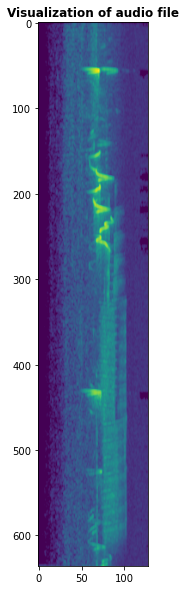

In [6]:
# Visualize an melspectogram example
plt.figure(figsize=(15,10))
plt.title('Visualization of audio file', weight='bold')
plt.imshow(X[0]);

In [7]:
# Save spectograms as PKL format

import pickle

with open('X_train.pkl', 'wb') as f:
    pickle.dump(X, f)
    
with open('y_train.pkl', 'wb') as x:
    pickle.dump(y, x)

Here the data is ready to be consumed by an RNN, LSTM, CNN or other.

**Do not hesitate to upvote if it was useful to you**